In [141]:
import warnings
warnings.filterwarnings('ignore')

import glob
# import math
import astropy.units as u
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
import os
import sunpy
import numpy as np
import requests
import gzip
import urllib.request
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sunpy.map import Map
from sunpy.sun import constants as const
from sunpy.coordinates import frames
from sunpy.coordinates import sun
import pfsspy
import pfsspy.tracing as tracing
from sunkit_instruments import suvi
import matplotlib.colors as colors
from astropy.visualization import ImageNormalize, LogStretch, LogStretch, PercentileInterval
from tqdm import tqdm

plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# set the directory path where the data is importe/stored
data_dir = '/home/mnedal/data'
basedir = '/home/mnedal/data/'
savedir = '/home/mnedal/repos/dias_work'

Select the date and time of the observation 

In [7]:
YEAR = '2024'
MONTH = '05'
DAY = '14'
HOUR = '17'
MINUTE = '40'

# construct the datetime object 
mydatetime = datetime(int(YEAR), int(MONTH), int(DAY), int(HOUR), int(MINUTE))

# get the Carrington rotation number at the specified datetime 
cr = str(int(sun.carrington_rotation_number(t=mydatetime)))
print(cr)

# set the field of view of LOFAR observations 
FOV = 3750

2284


In [5]:
def find_links(url='http://www.python.org'):
    """
    Get all the links in a webpage. 
    Source: https://stackoverflow.com/questions/20150184/make-a-list-of-all-the-files-on-a-website 
    """
    soup = BeautifulSoup(requests.get(url).text)
    hrefs = []
    for a in soup.find_all('a'):
        hrefs.append(a['href'])
    return hrefs

In [6]:
# show the links of the GONG files 
gong_url = 'https://gong2.nso.edu/oQR/zqs/%s%s/mrzqs%s%s%s/' %(YEAR, MONTH, YEAR[-2:], MONTH, DAY)
list_gong_links = find_links(url=gong_url)

# show what you've found 
for i, link in enumerate(list_gong_links):
    print(i, link)

0 ?C=N;O=D
1 ?C=M;O=A
2 ?C=S;O=A
3 ?C=D;O=A
4 /oQR/zqs/202405/
5 mrzqs240514t0004c2284_201.fits.gz
6 mrzqs240514t0104c2284_200.fits.gz
7 mrzqs240514t0114c2284_200.fits.gz
8 mrzqs240514t0244c2284_199.fits.gz
9 mrzqs240514t0454c2284_198.fits.gz
10 mrzqs240514t0604c2284_197.fits.gz
11 mrzqs240514t0704c2284_197.fits.gz
12 mrzqs240514t0814c2284_196.fits.gz
13 mrzqs240514t0914c2284_196.fits.gz
14 mrzqs240514t1004c2284_195.fits.gz
15 mrzqs240514t1114c2284_194.fits.gz
16 mrzqs240514t1204c2284_194.fits.gz
17 mrzqs240514t1304c2284_193.fits.gz
18 mrzqs240514t1414c2284_193.fits.gz
19 mrzqs240514t1514c2284_192.fits.gz
20 mrzqs240514t1614c2284_192.fits.gz
21 mrzqs240514t1714c2284_191.fits.gz
22 mrzqs240514t1814c2284_191.fits.gz
23 mrzqs240514t1904c2284_190.fits.gz
24 mrzqs240514t2004c2284_190.fits.gz
25 mrzqs240514t2104c2284_189.fits.gz
26 mrzqs240514t2204c2284_189.fits.gz
27 mrzqs240514t2354c2284_187.fits.gz


Choose which file to download 

In [170]:
gong_file_index = 21
gong_filename = list_gong_links[gong_file_index]

print(basedir + gong_filename)

/home/mnedal/data/mrzqs240514t1714c2284_191.fits.gz


Load a GONG magnetic field map at the specified datetime 

In [171]:
if not os.path.exists(basedir + gong_filename[:-3]) and not os.path.exists(basedir + gong_filename):
    urllib.request.urlretrieve(url=gong_url+gong_filename, filename=basedir+gong_filename)

if not os.path.exists(basedir + gong_filename[:-3]):
    with gzip.open(basedir + gong_filename, 'rb') as f:
        with open(basedir + gong_filename[:-3], 'wb') as g:
            g.write(f.read())

In [172]:
# make a sunpy map of the file 
gong_map = Map(basedir + gong_filename[:-3])

Load the corresponding SUVI 195$\\A^o$ map 

In [93]:
def load_suvi(start=None, end=None, channel=195):
    """
    * 9.4 nm (FeXVIII)
    * 13.1 nm (FeXXI)
    * 17.1 nm (FeIX/X)
    * 19.5 nm (FeXII)
    * 28.4 nm (FeXV)
    * 30.4 nm (HeII)
    """
    dt_dict = split_datetime(start=start, end=end)
    data_path = f"{data_dir}/SUVI/{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}/{channel}A"
    root_filename = f"dr_suvi-l2-ci{channel}_g18_s"
    data = sorted(glob.glob(f"{data_path}/{root_filename}{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}*.fits"))
    
    start_file_to_find = f"{data_path}/{root_filename}{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}T{dt_dict['start_hour']}0000Z_e{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}T{dt_dict['start_hour']}0400Z_v1-0-2.fits"
    end_file_to_find   = f"{data_path}/{root_filename}{dt_dict['end_year']}{dt_dict['end_month']}{dt_dict['end_day']}T{dt_dict['end_hour']}2800Z_e{dt_dict['end_year']}{dt_dict['end_month']}{dt_dict['end_day']}T{dt_dict['end_hour']}3200Z_v1-0-2.fits"
    
    idx1 = data.index(start_file_to_find)
    idx2 = data.index(end_file_to_find)
    
    chosen_files = data[idx1:idx2]
    
    map_objects = []
    for i, file in enumerate(chosen_files):
        m = suvi.files_to_map(file, despike_l1b=True)
        min_range = 0
        if channel == 94:
            max_range = 20
        elif channel == 171:
            max_range = 20
        elif channel == 131:
            max_range = 20
        elif channel == 195:
            max_range = 50
        elif channel == 284:
            max_range = 50
        elif channel == 304:
            max_range = 100
        
        m.plot_settings['norm'] = ImageNormalize(vmin=min_range, vmax=max_range, stretch=LogStretch())
        map_objects.append(m)
        print(f'SUVI image {i} is done')
    return map_objects



def load_lasco(start=None, end=None, detector='C2'):
    """
    Load SOHO/LASCO C2 or C3 images as sunpy maps.
    """
    dt_dict = split_datetime(start=start, end=end)
    data = sorted(glob.glob(f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}*.jp2"))
    
    start_file_to_find = f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['end_year']}{dt_dict['start_month']}{dt_dict['start_day']}T{dt_dict['start_hour']}{dt_dict['start_minute']}.jp2"
    end_file_to_find = f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['end_year']}{dt_dict['end_month']}{dt_dict['end_day']}T{dt_dict['end_hour']}{dt_dict['end_minute']}.jp2"
    
    idx1 = data.index(start_file_to_find)
    idx2 = data.index(end_file_to_find)
    chosen_files = data[idx1:idx2]
    
    map_objects = []
    for i, file in enumerate(chosen_files):
        m = sunpy.map.Map(file)
        m.meta['bunit'] = 'ct' # a workaround for C2 and C3 jp2 images
        m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=250)
        map_objects.append(m)
        print(f'LASCO {detector} image {i} is done')
    return map_objects



def split_datetime(start=None, end=None):
    
    START_DATE, START_TIME = start.split('T')
    END_DATE, END_TIME = end.split('T')

    START_YEAR, START_MONTH, START_DAY = START_DATE.split('-')
    END_YEAR, END_MONTH, END_DAY = END_DATE.split('-')

    START_HOUR, START_MINUTE, START_SECOND = START_TIME.split(':')
    END_HOUR, END_MINUTE, END_SECOND = END_TIME.split(':')

    datetime_dict = {
        'start_year': START_YEAR,
        'start_month': START_MONTH,
        'start_day': START_DAY,
        'start_hour': START_HOUR,
        'start_minute': START_MINUTE,
        'start_second': START_SECOND,
        
        'end_year': END_YEAR,
        'end_month': END_MONTH,
        'end_day': END_DAY,
        'end_hour': END_HOUR,
        'end_minute': END_MINUTE,
        'end_second': END_SECOND
    }
    return datetime_dict




def remove_redundant_maps(maps):
    """
    Remove redundant SunPy maps, keeping only one map per unique timestamp.

    Parameters:
    maps (list): List of SunPy Map objects. Each map is expected to have a 'date-obs' 
                 key in its metadata that provides the observation timestamp.

    Returns:
    list: A list of unique SunPy Map objects, one per unique timestamp.
    
    Example:
    >>> unique_maps = remove_redundant_maps(list_of_sunpy_maps)
    """
    unique_maps = {}
    for m in maps:
        timestamp = m.latex_name
        if timestamp not in unique_maps:
            unique_maps[timestamp] = m
    return list(unique_maps.values())



def apply_runratio(maps):
    """
    Apply running-ratio image technique on EUV images.
    See: https://iopscience.iop.org/article/10.1088/0004-637X/750/2/134/pdf
        Inputs: list of EUV sunpy maps.
        Output: sequence of run-ratio sunpy maps.
    """
    runratio = [m / prev_m.quantity for m, prev_m in zip(maps[1:], maps[:-1])]
    m_seq_runratio = sunpy.map.Map(runratio, sequence=True)
    
    for m in m_seq_runratio:
        m.data[np.isnan(m.data)] = 1
        m.plot_settings['norm'] = colors.Normalize(vmin=0, vmax=2)
        m.plot_settings['cmap'] = 'Greys_r'
    
    return m_seq_runratio



def enhance_contrast(image, vmin, vmax):
    """
    Enhance contrast by clipping and normalization.
    """
    image_clipped = np.clip(image, vmin, vmax)
    image_normalized = (image_clipped - vmin) / (vmax - vmin)
    return image_normalized



def calculate_percentiles(image, lower_percentile=3, upper_percentile=97):
    """
    Calculate vmin and vmax based on the 1st and 99th percentiles.
    """
    vmin = np.percentile(image, lower_percentile)
    vmax = np.percentile(image, upper_percentile)
    return vmin, vmax

In [27]:
suvi_map_objects = load_suvi(start='2024-05-14T17:00:00', end='2024-05-14T18:00:00', channel=195)

SUVI image 0 is done
SUVI image 1 is done
SUVI image 2 is done
SUVI image 3 is done
SUVI image 4 is done
SUVI image 5 is done
SUVI image 6 is done
SUVI image 7 is done
SUVI image 8 is done
SUVI image 9 is done
SUVI image 10 is done
SUVI image 11 is done
SUVI image 12 is done
SUVI image 13 is done
SUVI image 14 is done
SUVI image 15 is done
SUVI image 16 is done
SUVI image 17 is done
SUVI image 18 is done
SUVI image 19 is done
SUVI image 20 is done
SUVI image 21 is done


In [34]:
clean_suvi_maps = remove_redundant_maps(suvi_map_objects)
suvi_seq_runratio = apply_runratio(clean_suvi_maps)

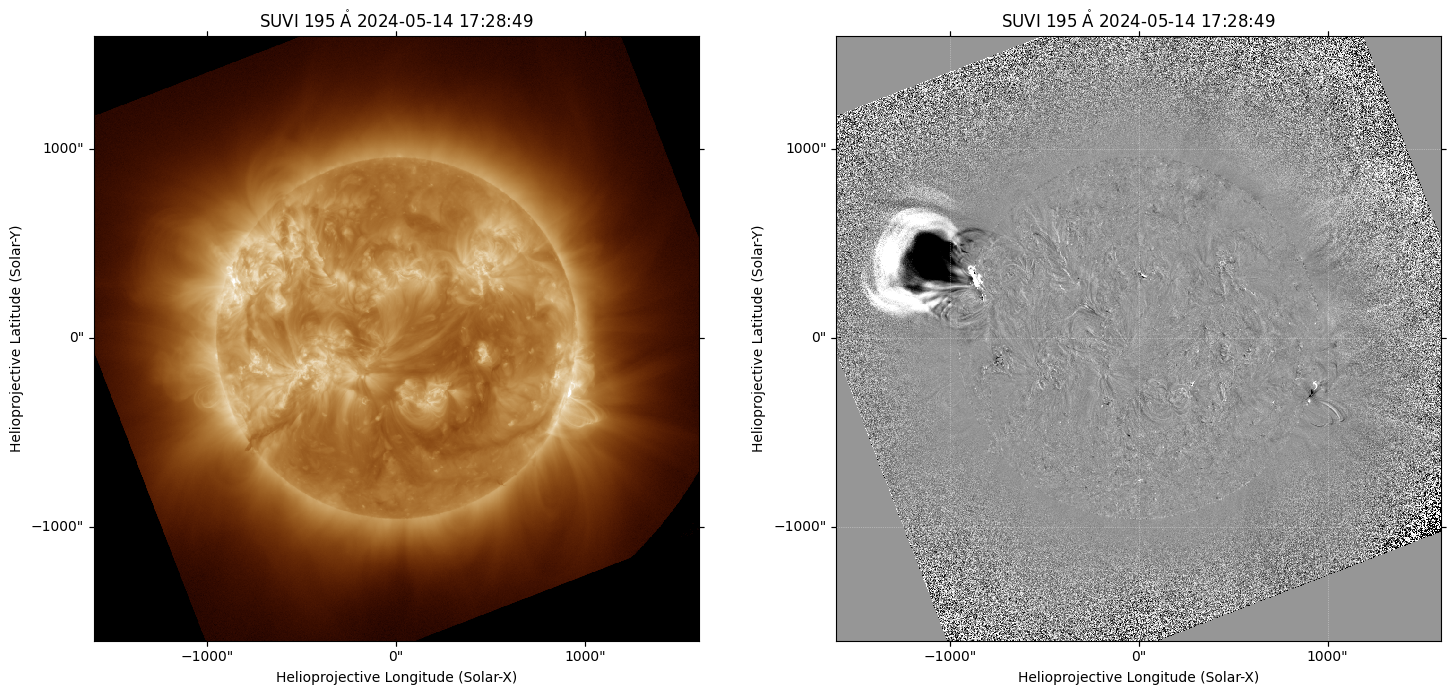

In [48]:
index = 7
m = suvi_seq_runratio[index-1]
m.plot_settings['norm'] = colors.Normalize(vmin=0.7, vmax=1.3)
suvi_map = clean_suvi_maps[index]

fig = plt.figure(figsize=[15,7])

ax = fig.add_subplot(121, projection=suvi_map)
suvi_map.plot(axes=ax)
ax.grid(False)
# ax.set_xlim(left=0, right=400)
# ax.set_ylim(bottom=600, top=1000)

ax = fig.add_subplot(122, projection=m)
m.plot(axes=ax, cmap='Greys_r')
# ax.set_xlim(left=0, right=400)
# ax.set_ylim(bottom=600, top=1000)

fig.tight_layout()
plt.show()

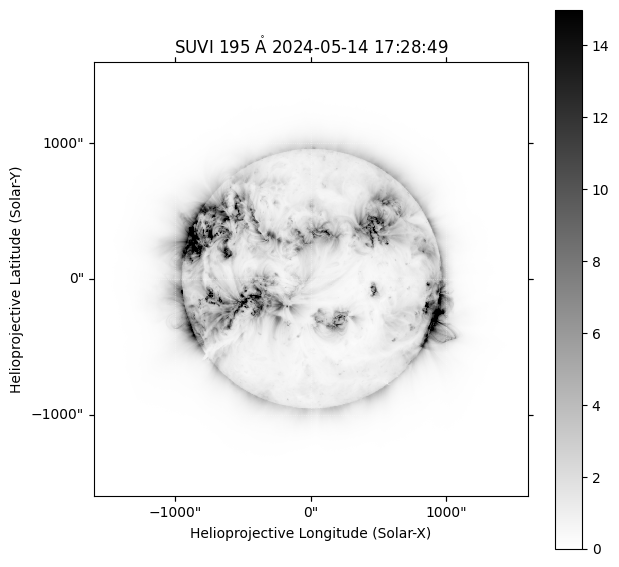

In [77]:
suvi_map = clean_suvi_maps[index]
suvi_map.plot_settings['norm'] = colors.Normalize(vmin=0, vmax=15)

fig = plt.figure()
ax = plt.subplot(projection=suvi_map)
img = suvi_map.plot(axes=ax, cmap='gray_r')
plt.colorbar(img)
plt.show()

## The PFSS Model

* The Sun’s magnetic field is complex and highly dynamic, particularly in the corona.
* Near the Sun’s surface, the magnetic field lines are closed, forming loops.
* As you move further from the Sun, these loops open up and the magnetic field becomes more radial.
* The PFSS model helps simplify this complex structure by assuming that at a certain distance from the Sun, called the source surface, the magnetic field transitions to this radial state.
* Below the source surface, the model assumes the magnetic field is potential, meaning it is derived from a scalar potential and has no electric currents (it is curl-free).
* This is an approximation that helps in solving the magnetic field equations more easily.
* The source surface is typically set at a radius of about 2.5 $R_\odot$.
* This value is chosen because it roughly corresponds to where solar wind starts to dominate, stretching the magnetic field lines into a radial configuration.
* The parameter `r`, which is set to 1.2 $R_\odot$ represents the radial distance from the center of the Sun at which you are starting the tracing of magnetic field lines.
* The value 1.2 is commonly chosen because it lies in the lower corona, where the magnetic field structure is still influenced by the solar surface but is starting to show the effects of the solar wind and the transition to more open field structures.
* In the PFSS model, the magnetic field is computed between the Sun’s surface and the source surface (often at 2.5 $R_\odot$).
* By setting `r` to 1.2 $R_\odot$, you are examining the magnetic field lines within this region, but closer to the Sun’s surface rather than at the outer boundary.

The [PFSS](https://pfsspy.readthedocs.io/en/stable/) solution is calculated on a regular 3D grid in (phi, s, rho), where
rho = ln(r), and r is the standard spherical radial coordinate.

We need to define the number of grid points in rho, and the source surface radius.

From the boundary condition, number of radial grid points, and source surface, we now construct an `Input` object that stores this information.

Using the `Input` object, plot the input photospheric magnetic field.

In [173]:
# fix a bug in the GONG map file
if 'cunit1' not in gong_map.meta:
    gong_map.meta['cunit1'] = u.deg

In [174]:
nrho = 50 # umber of rho grid points
rss = 3   # source surface radius
pfss_in = pfsspy.Input(gong_map, nrho, rss)
pfss_out = pfsspy.pfss(pfss_in)

Now we construct a lat x lon grid of footpoitns to trace some magnetic field lines from.

These coordinates are defined in the helioprojective frame of the SUVI image.

In [175]:
num_footpoints = 20
lat = np.linspace(-0.4*np.pi, 0.5*np.pi, num_footpoints, endpoint=False)
lon = np.linspace(-0.5*np.pi, 1.5*np.pi, num_footpoints+10, endpoint=False)

lat, lon = np.meshgrid(lat, lon, indexing='ij')
lat, lon = lat.ravel()*u.rad, lon.ravel()*u.rad
r = 1.2*const.radius

# Make a 2D grid from these 1D points 
seeds = SkyCoord(lon, lat, r, frame=pfss_out.coordinate_frame)
tracer = tracing.FortranTracer()
flines = tracer.trace(seeds, pfss_out)

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


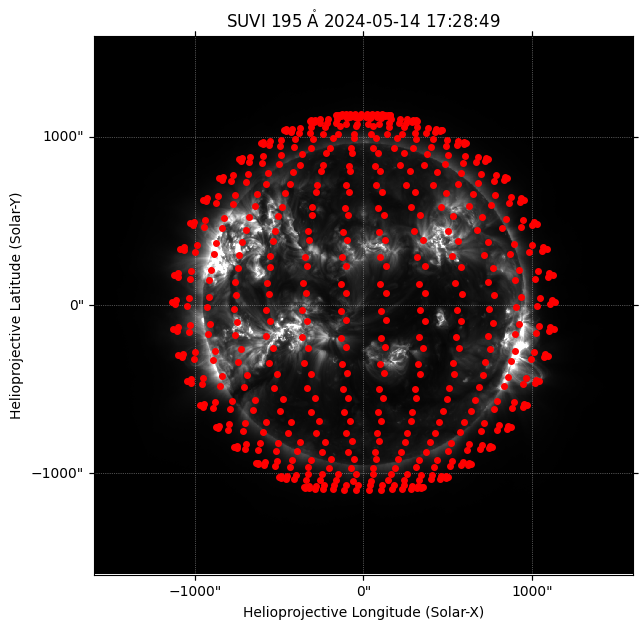

In [176]:
# Map of the footpoints
fig = plt.figure()
ax = plt.subplot(projection=suvi_map)
suvi_map.plot(axes=ax, cmap='gray')
ax.plot_coord(seeds, color='red', marker='o', markersize=4, linewidth=0)
plt.show()

Plot the magnetogram and the seed footpoints. The footpoints are centered around the active region metnioned above.

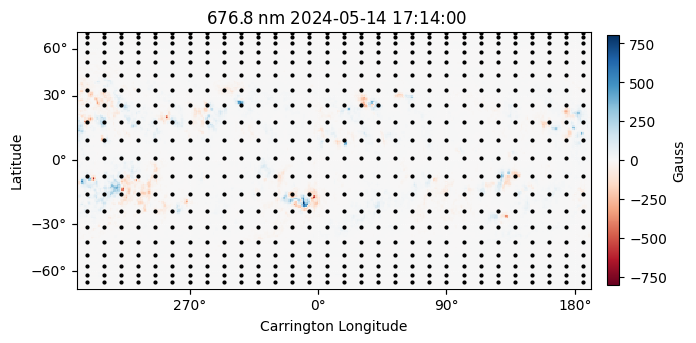

In [177]:
m = pfss_in.map
fig = plt.figure()
ax = plt.subplot(projection=m)
gon = m.plot()
ax.plot_coord(seeds, color='black', marker='o', linewidth=0, markersize=2)
fig.colorbar(gon, fraction=0.023, pad=0.03, label=pfss_in.map.meta['bunit'])
plt.show()

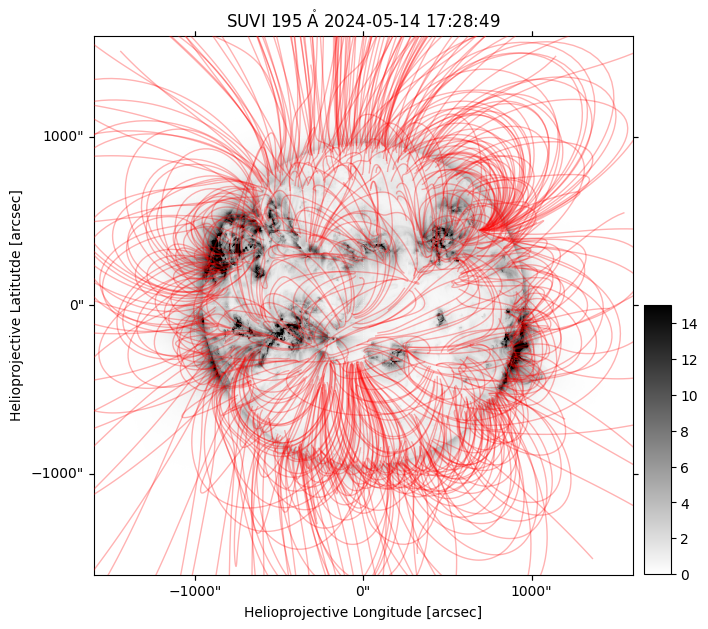

In [81]:
fig = plt.figure()
ax = plt.subplot(111, projection=suvi_map)
im = suvi_map.plot(axes=ax, cmap='gray_r')
# suvi_map.draw_limb()
# suvi_map.draw_grid()

for fline in flines:
    ax.plot_coord(fline.coords, alpha=0.3, color='red', linewidth=1)

axins = inset_axes(ax,
                   width='5%',    # width = 5% of parent_bbox width 
                   height='50%',  # height : 50% 
                   loc='lower left', bbox_to_anchor=(1.02,0,1,1), bbox_transform=ax.transAxes, borderpad=0.01)
fig.colorbar(im, cax=axins)
ax.set_xlabel('Helioprojective Longitude [arcsec]')
ax.set_ylabel('Helioprojective Latitutde [arcsec]')
ax.set_xlim(left=0, right=int(suvi_map.dimensions.x.value))
ax.set_ylim(bottom=0, top=int(suvi_map.dimensions.y.value))
plt.show()

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


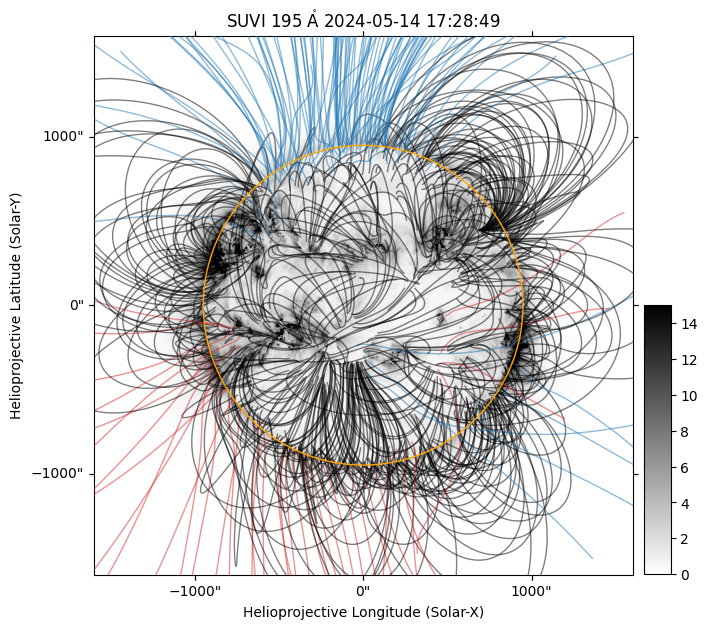

In [88]:
fig = plt.figure()
ax = plt.subplot(111, projection=suvi_map)
im = suvi_map.plot(axes=ax, cmap='gray_r')
suvi_map.draw_limb(color='orange')

for fline in flines:
    color = {0: 'black', -1: 'tab:blue', 1: 'tab:red'}.get(fline.polarity)
    ax.plot_coord(fline.coords, alpha=0.5, color=color, linewidth=1)

axins = inset_axes(ax,
                   width='5%',    # width = 5% of parent_bbox width 
                   height='50%',  # height : 50% 
                   loc='lower left', bbox_to_anchor=(1.02,0,1,1), bbox_transform=ax.transAxes, borderpad=0.01)
fig.colorbar(im, cax=axins)
# ax.set_xlabel('Helioprojective Longitude [arcsec]')
# ax.set_ylabel('Helioprojective Latitutde [arcsec]')
ax.set_xlim(left=0, right=int(suvi_map.dimensions.x.value))
ax.set_ylim(bottom=0, top=int(suvi_map.dimensions.y.value))
plt.show()

Plot the Running-Ratio GOES/SUVI 195$\\A^o$ with the PFSS Model

Plotting the field lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [01:31<00:00,  6.58it/s]


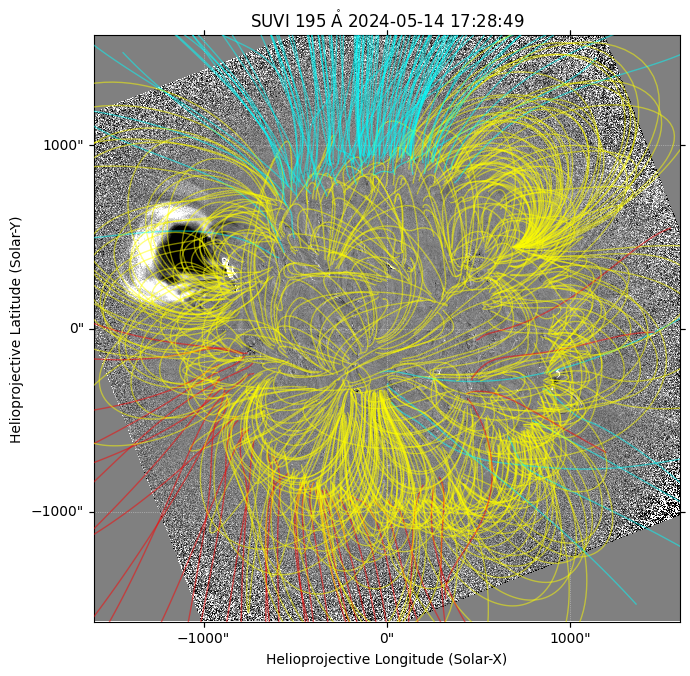

In [178]:
m = suvi_seq_runratio[index-1]
m.plot_settings['norm'] = colors.Normalize(vmin=0.7, vmax=1.3)

fig = plt.figure()
ax = plt.subplot(projection=m)
m.plot(axes=ax, cmap='gray')

with tqdm(total=len(flines), desc='Plotting the field lines') as pbar:
    for fline in flines:
        color = {0:'yellow', -1:'cyan', 1:'red'}.get(fline.polarity)
        ax.plot_coord(fline.coords, alpha=0.5, color=color, linewidth=1)
        pbar.update(1)

ax.set_xlim(left=0, right=int(m.dimensions.x.value))
ax.set_ylim(bottom=0, top=int(m.dimensions.y.value))
fig.tight_layout()
fig.savefig(f'{data_dir}/SUVI_195A_runratio_PFSS.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Plot the GOES/SUVI 195$\\A^o$ with the LASCO C2 image

In [94]:
lasco_c2_map_objects = load_lasco(start='2024-05-14T17:30:00', end='2024-05-14T20:00:00', detector='C2')

LASCO C2 image 0 is done
LASCO C2 image 1 is done
LASCO C2 image 2 is done
LASCO C2 image 3 is done
LASCO C2 image 4 is done
LASCO C2 image 5 is done
LASCO C2 image 6 is done
LASCO C2 image 7 is done
LASCO C2 image 8 is done
LASCO C2 image 9 is done
LASCO C2 image 10 is done
LASCO C2 image 11 is done
LASCO C2 image 12 is done
LASCO C2 image 13 is done
LASCO C2 image 14 is done
LASCO C2 image 15 is done
LASCO C2 image 16 is done
LASCO C2 image 17 is done
LASCO C2 image 18 is done
LASCO C2 image 19 is done
LASCO C2 image 20 is done
LASCO C2 image 21 is done
LASCO C2 image 22 is done
LASCO C2 image 23 is done
LASCO C2 image 24 is done
LASCO C2 image 25 is done
LASCO C2 image 26 is done
LASCO C2 image 27 is done
LASCO C2 image 28 is done
LASCO C2 image 29 is done
LASCO C2 image 30 is done
LASCO C2 image 31 is done
LASCO C2 image 32 is done
LASCO C2 image 33 is done
LASCO C2 image 34 is done
LASCO C2 image 35 is done
LASCO C2 image 36 is done
LASCO C2 image 37 is done
LASCO C2 image 38 is d

In [95]:
# remove redundant images
clean_maps_c2 = remove_redundant_maps(lasco_c2_map_objects)

print(f'Before:\nLASCO C2: {len(lasco_c2_map_objects)} images\n')
print(f'After:\nLASCO C2: {len(clean_maps_c2)} images')

Before:
LASCO C2: 150 images

After:
LASCO C2: 13 images


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


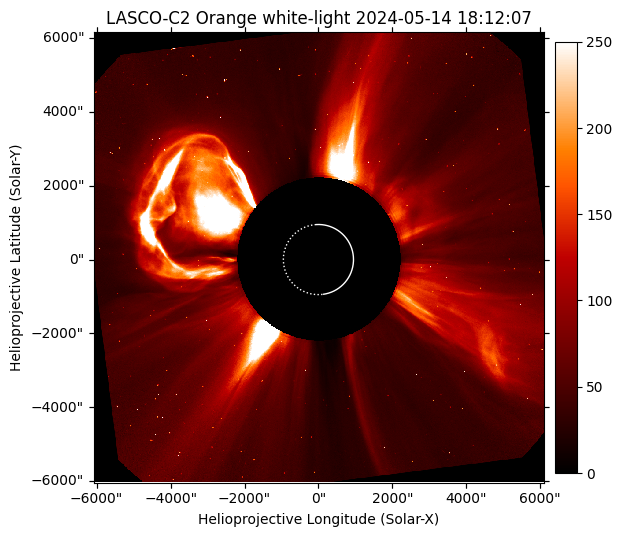

In [97]:
m_c2 = clean_maps_c2[4]

fig = plt.figure()
ax = fig.add_subplot(111, projection=m_c2)
img = m_c2.plot(axes=ax)
m.draw_limb()
ax.grid(False)
plt.colorbar(img, pad=0.02, shrink=0.8)
plt.show()

In [98]:
# make run-diff maps
m_seq_runratio_c2 = apply_runratio(clean_maps_c2)

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


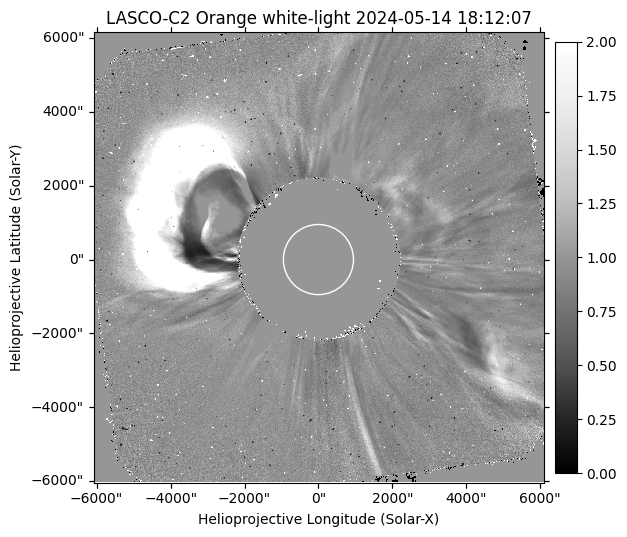

In [103]:
m_c2_rr = m_seq_runratio_c2[3]

fig = plt.figure()
ax = fig.add_subplot(111, projection=m_c2_rr)
img = m_c2_rr.plot(axes=ax)
m_c2_rr.draw_limb()
ax.grid(False)
plt.colorbar(img, pad=0.02, shrink=0.8)

# ax.set_xlim(left=-120, right=400)
# ax.set_ylim(bottom=400, top=850)
plt.show()

Load the nearest in time GONG map to LASCO C2 time

In [104]:
gong_file_index = 22
gong_filename = list_gong_links[gong_file_index]

print(basedir + gong_filename)

/home/mnedal/data/mrzqs240514t1814c2284_191.fits.gz


In [105]:
if not os.path.exists(basedir + gong_filename[:-3]) and not os.path.exists(basedir + gong_filename):
    urllib.request.urlretrieve(url=gong_url+gong_filename, filename=basedir+gong_filename)

if not os.path.exists(basedir + gong_filename[:-3]):
    with gzip.open(basedir + gong_filename, 'rb') as f:
        with open(basedir + gong_filename[:-3], 'wb') as g:
            g.write(f.read())

In [146]:
gong_map = Map(basedir + gong_filename[:-3])

if 'cunit1' not in gong_map.meta:
    gong_map.meta['cunit1'] = u.deg

nrho = 50 # umber of rho grid points
rss  = 7  # source surface radius
pfss_in  = pfsspy.Input(gong_map, nrho, rss)
pfss_out = pfsspy.pfss(pfss_in)

num_footpoints = 20
lat = np.linspace(-0.4*np.pi, 0.5*np.pi, num_footpoints, endpoint=False)
lon = np.linspace(-0.5*np.pi, 1.5*np.pi, num_footpoints+10, endpoint=False)

lat, lon = np.meshgrid(lat, lon, indexing='ij')
lat, lon = lat.ravel()*u.rad, lon.ravel()*u.rad
r = 1.2*const.radius

# Make a 2D grid from these 1D points 
seeds  = SkyCoord(lon, lat, r, frame=pfss_out.coordinate_frame)
tracer = tracing.FortranTracer()
flines = tracer.trace(seeds, pfss_out)

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


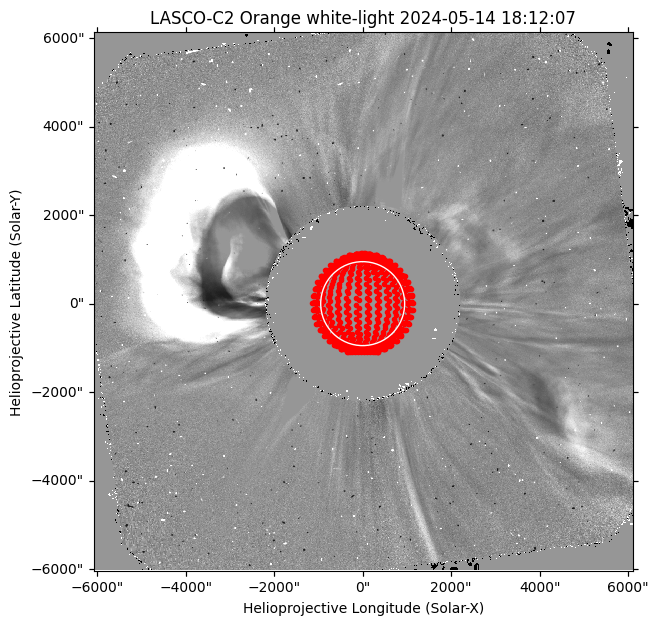

In [147]:
# Map of the footpoints
fig = plt.figure()
ax = fig.add_subplot(111, projection=m_c2_rr)
m_c2_rr.plot(axes=ax)
ax.plot_coord(seeds, color='red', marker='o', markersize=3, linewidth=0)
m_c2_rr.draw_limb()
ax.grid(False)
plt.show()

In [148]:
lat_ss = np.linspace(-0.4*np.pi, 0.5*np.pi, num_footpoints, endpoint=False)
lon_ss = np.linspace(-0.5*np.pi, 1.5*np.pi, num_footpoints+30, endpoint=False)

lat_ss, lon_ss = np.meshgrid(lat_ss, lon_ss, indexing='ij')
lat_ss, lon_ss = lat_ss.ravel()*u.rad, lon_ss.ravel()*u.rad
ss = SkyCoord(lon_ss, lat_ss, rss*const.radius, frame=pfss_out.coordinate_frame)

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


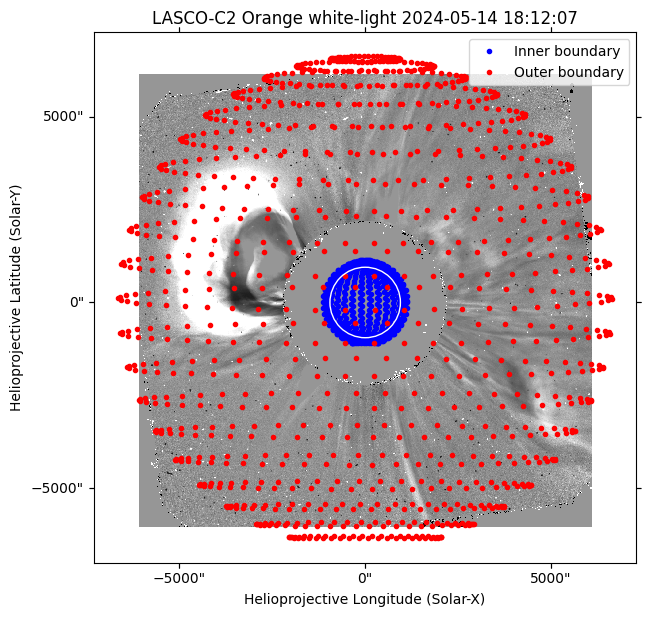

In [149]:
# Map of the footpoints
fig = plt.figure()
ax = fig.add_subplot(111, projection=m_c2_rr)
m_c2_rr.plot(axes=ax)
ax.plot_coord(seeds, color='blue', marker='o', markersize=3, linewidth=0, label='Inner boundary')
ax.plot_coord(ss, color='red', marker='o', markersize=3, linewidth=0, label='Outer boundary')
m_c2_rr.draw_limb()
ax.grid(False)
ax.legend(loc='best')
plt.show()

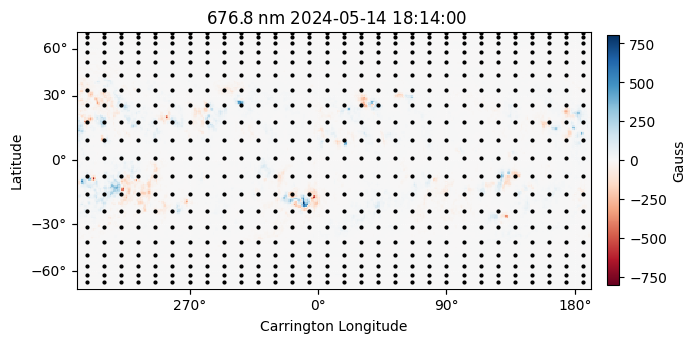

In [150]:
m = pfss_in.map
fig = plt.figure()
ax = plt.subplot(projection=m)
gon = m.plot()
ax.plot_coord(seeds, color='black', marker='o', linewidth=0, markersize=2)
fig.colorbar(gon, fraction=0.023, pad=0.03, label=pfss_in.map.meta['bunit'])
plt.show()

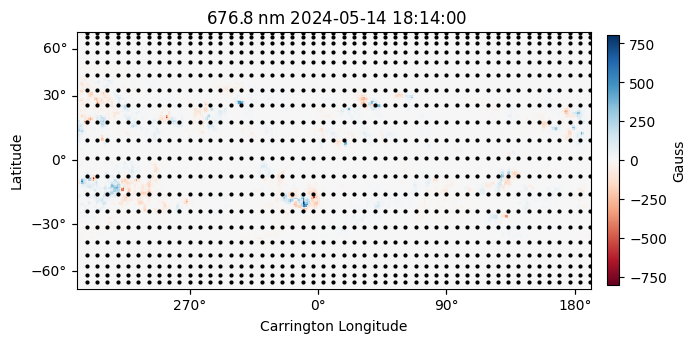

In [151]:
m = pfss_in.map
fig = plt.figure()
ax = plt.subplot(projection=m)
gon = m.plot()
ax.plot_coord(ss, color='black', marker='o', linewidth=0, markersize=2)
fig.colorbar(gon, fraction=0.023, pad=0.03, label=pfss_in.map.meta['bunit'])
plt.show()

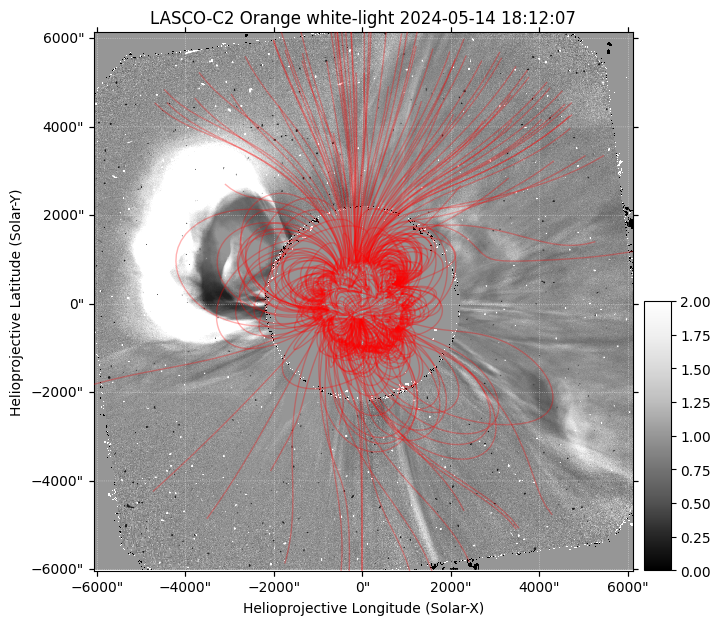

In [116]:
fig = plt.figure()
ax = plt.subplot(111, projection=m_c2_rr)
im = m_c2_rr.plot(axes=ax)

for fline in flines:
    ax.plot_coord(fline.coords, alpha=0.3, color='red', linewidth=1)

axins = inset_axes(ax,
                   width='5%',    # width = 5% of parent_bbox width 
                   height='50%',  # height : 50% 
                   loc='lower left', bbox_to_anchor=(1.02,0,1,1), bbox_transform=ax.transAxes, borderpad=0.01)
fig.colorbar(im, cax=axins)
ax.set_xlim(left=0, right=int(m_c2_rr.dimensions.x.value))
ax.set_ylim(bottom=0, top=int(m_c2_rr.dimensions.y.value))
plt.show()

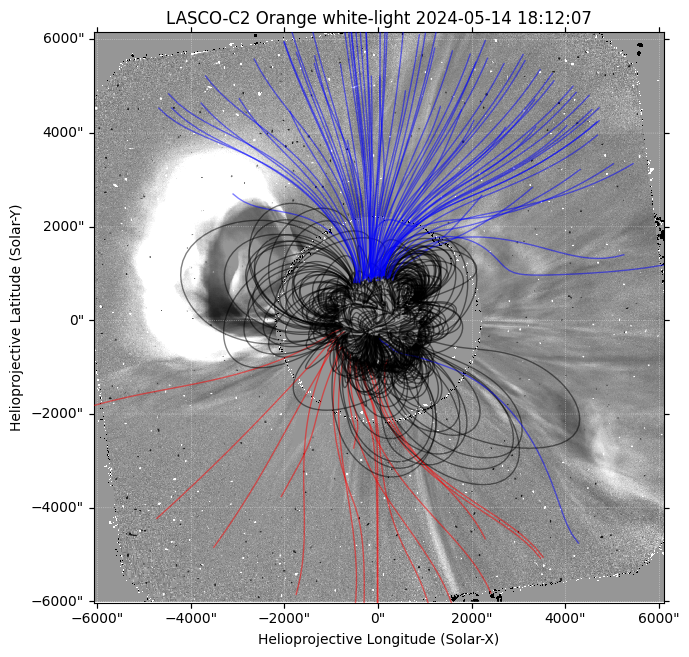

In [167]:
fig = plt.figure()
ax = plt.subplot(111, projection=m_c2_rr)
im = m_c2_rr.plot(axes=ax)

for fline in flines:
    # color = {0: 'black', -1: 'tab:blue', 1: 'tab:red'}.get(fline.polarity)
    color = {0:'black', -1:'blue', 1:'red'}.get(fline.polarity)
    ax.plot_coord(fline.coords, alpha=0.5, color=color, linewidth=1)

# axins = inset_axes(ax,
#                    width='5%',    # width = 5% of parent_bbox width 
#                    height='50%',  # height : 50% 
#                    loc='lower left', bbox_to_anchor=(1.02,0,1,1), bbox_transform=ax.transAxes, borderpad=0.01)
# fig.colorbar(im, cax=axins)
ax.set_xlim(left=0, right=int(m_c2_rr.dimensions.x.value))
ax.set_ylim(bottom=0, top=int(m_c2_rr.dimensions.y.value))
fig.tight_layout()
fig.savefig(f'{data_dir}/LASCO_C2_runratio_PFSS.pdf', format='pdf', bbox_inches='tight')
# fig.savefig(f'{data_dir}/LASCO_C2_runratio_PFSS.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


Plotting the field lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [01:34<00:00,  6.36it/s]


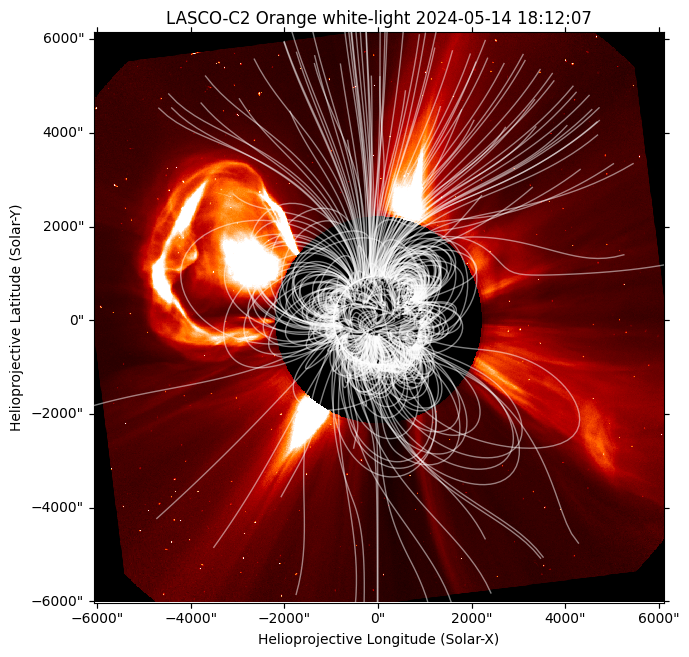

In [168]:
m_c2 = clean_maps_c2[4]

fig = plt.figure()
ax = fig.add_subplot(111, projection=m_c2)
m_c2.plot(axes=ax)
m.draw_limb()

with tqdm(total=len(flines), desc='Plotting the field lines') as pbar:
    for fline in flines:
        ax.plot_coord(fline.coords, alpha=0.5, color='white', linewidth=1)
        pbar.update(1)

ax.grid(False)
ax.set_xlim(left=0, right=int(m_c2.dimensions.x.value))
ax.set_ylim(bottom=0, top=int(m_c2.dimensions.y.value))
fig.tight_layout()
fig.savefig(f'{data_dir}/LASCO_C2_PFSS.pdf', format='pdf', bbox_inches='tight')
plt.show()

Plotting the field lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 78.51it/s]


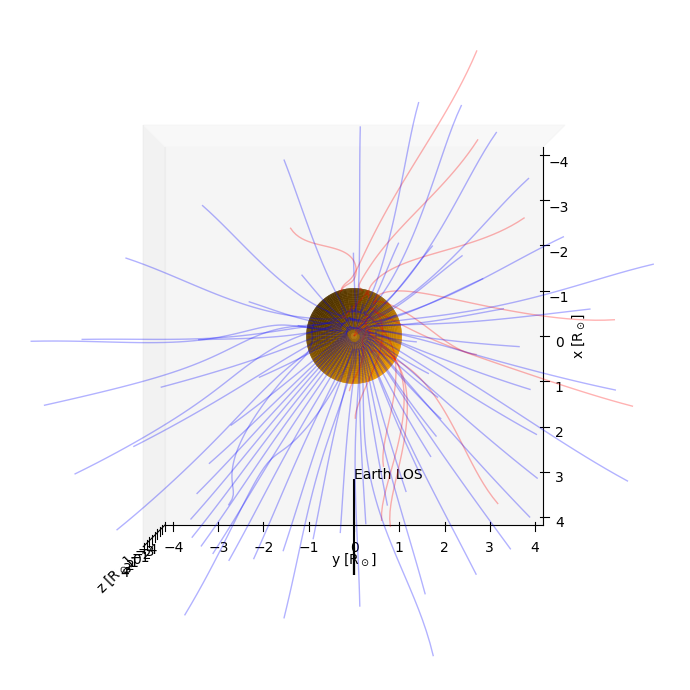

In [161]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

theta, phi = np.mgrid[0:np.pi:100j, 0:2*np.pi:100j]
x = np.sin(theta)*np.cos(phi) 
y = np.sin(theta)*np.sin(phi) 
z = np.cos(theta)
ax.plot_surface(x, y, z, color='orange', zorder=0)

with tqdm(total=len(flines), desc='Plotting the field lines') as pbar:
    for n, field_line in enumerate(flines):
        color = {0:'black', -1:'blue', 1:'red'}.get(field_line.polarity)
        coords = field_line.coords
        coords.representation_type = 'cartesian'
        x_line = coords.x/const.radius
        y_line = coords.y/const.radius
        z_line = coords.z/const.radius
        # ax.plot3D(x_line, y_line, z_line, alpha=0.3, color=color, linewidth=1, zorder=10)
        if field_line.polarity==1 or field_line.polarity==-1:
            alpha = 0.3
        else:
            alpha = 0
        ax.plot3D(x_line, y_line, z_line, alpha=alpha, color=color, linewidth=1, zorder=10)
        pbar.update(1)

# draw Sun-Earth LOS direction
x_pos = 3
y_pos = 0
z_pos = 0
x_direct = 1
y_direct = 0
z_direct = 0
ax.quiver(x_pos, y_pos, z_pos, x_direct, y_direct, z_direct, length=2, arrow_length_ratio=0.3, color='black')
ax.text(x_pos, y_pos, z_pos, 'Earth LOS', size=10, zorder=1, color='black')

ax.grid(False)
extent = 4
ax.set_xlim(-extent, extent)
ax.set_ylim(-extent, extent)
ax.set_zlim(-extent, extent)
ax.set_box_aspect([extent, extent, extent])
ax.view_init(elev=90, azim=0)
for axis in 'xyz':
    getattr(ax, 'set_{}label'.format(axis))(axis+' [R$_\odot]$')
plt.tight_layout()
plt.show()

Plotting the field lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 81.18it/s]


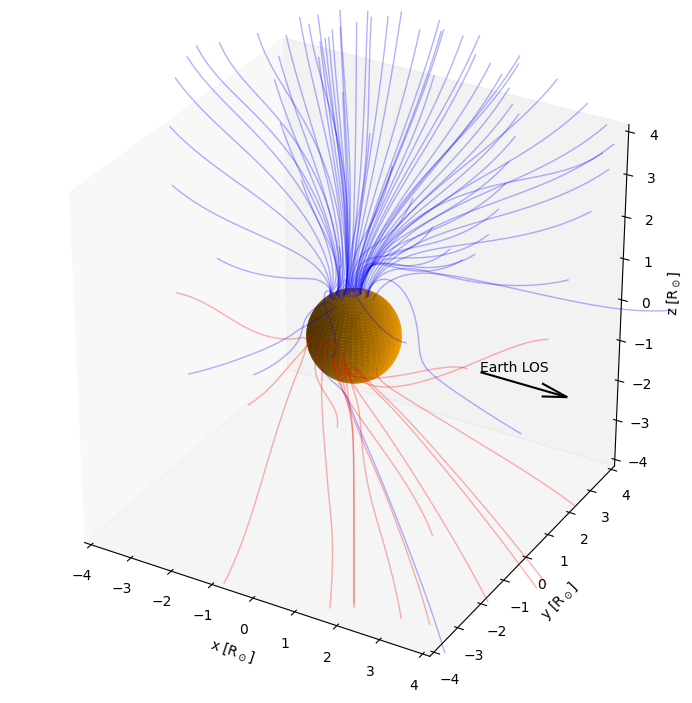

In [162]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

theta, phi = np.mgrid[0:np.pi:100j, 0:2*np.pi:100j]
x = np.sin(theta)*np.cos(phi) 
y = np.sin(theta)*np.sin(phi) 
z = np.cos(theta)
ax.plot_surface(x, y, z, color='orange', zorder=0)

with tqdm(total=len(flines), desc='Plotting the field lines') as pbar:
    for n, field_line in enumerate(flines):
        color = {0:'black', -1:'blue', 1:'red'}.get(field_line.polarity)
        coords = field_line.coords
        coords.representation_type = 'cartesian'
        x_line = coords.x/const.radius
        y_line = coords.y/const.radius
        z_line = coords.z/const.radius
        # ax.plot3D(x_line, y_line, z_line, alpha=0.3, color=color, linewidth=1, zorder=10)
        if field_line.polarity==1 or field_line.polarity==-1:
            alpha = 0.3
        else:
            alpha = 0
        ax.plot3D(x_line, y_line, z_line, alpha=alpha, color=color, linewidth=1, zorder=10)
        pbar.update(1)

# draw Sun-Earth LOS direction
x_pos = 3
y_pos = 0
z_pos = 0
x_direct = 1
y_direct = 0
z_direct = 0
ax.quiver(x_pos, y_pos, z_pos, x_direct, y_direct, z_direct, length=2, arrow_length_ratio=0.3, color='black')
ax.text(x_pos, y_pos, z_pos, 'Earth LOS', size=10, zorder=1, color='black')

ax.grid(False)
extent = 4
ax.set_xlim(-extent, extent)
ax.set_ylim(-extent, extent)
ax.set_zlim(-extent, extent)
ax.set_box_aspect([extent, extent, extent])
# ax.view_init(elev=90, azim=0)
for axis in 'xyz':
    getattr(ax, 'set_{}label'.format(axis))(axis+' [R$_\odot]$')
plt.tight_layout()
plt.show()

## Draw PFSS model on half Sun

Plotting the field lines: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 72.24it/s]


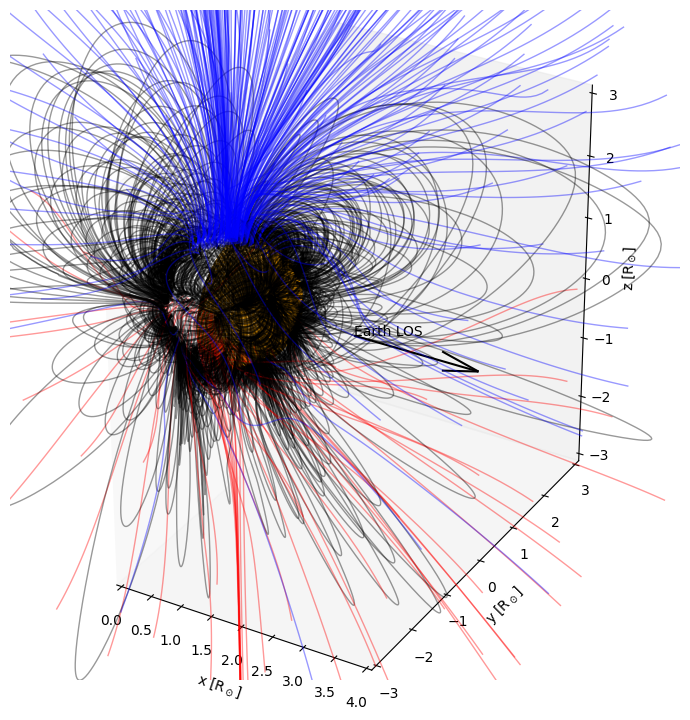

In [144]:






fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)

# draw half of the Sun
theta, phi = np.mgrid[0:np.pi:100j, 0:np.pi:100j]
x = np.sin(theta)*np.cos(phi) 
y = np.sin(theta)*np.sin(phi) 
z = np.cos(theta)

# applying rotation matrix to rotate the half of the Sun
Rx = np.array([[1, 0, 0],
               [0, np.cos(np.deg2rad(0)), -np.sin(np.deg2rad(0))],
               [0, np.sin(np.deg2rad(0)), np.cos(np.deg2rad(0))]])
x, y, z = np.einsum("ij,jkl->ikl", Rx, np.array([x, y, z]))
Rz = np.array([[np.cos(np.deg2rad(-90)), -np.sin(np.deg2rad(-90)), 0],
               [np.sin(np.deg2rad(-90)), np.cos(np.deg2rad(-90)), 0],
               [0, 0, 1]])
x, y, z = np.einsum("ij,jkl->ikl", Rz, np.array([x, y, z]))
ax.plot_surface(x, y, z, color='orange', zorder=0)

with tqdm(total=len(flines), desc='Plotting the field lines') as pbar:
    for n, field_line in enumerate(flines):
        color = {0:'black', -1:'blue', 1:'red'}.get(field_line.polarity)
        coords = field_line.coords
        coords.representation_type = 'cartesian'
        x_line = coords.x/const.radius
        y_line = coords.y/const.radius
        z_line = coords.z/const.radius
        ax.plot3D(x_line, y_line, z_line, alpha=0.4, color=color, linewidth=1, zorder=10)
        # if field_line.polarity==1 or field_line.polarity==-1:
        #     alpha_val = 0.4
        #     ax.plot3D(x_line, y_line, z_line, alpha=alpha_val, zorder=1, color=color, linewidth=1)
        # else:
        #     alpha_val = 0
        # ax.plot3D(x_line, y_line, z_line, alpha=alpha_val, zorder=1, color=color, linewidth=1)
        pbar.update(1)

# draw Sun-Earth LOS direction
x_pos = 2
y_pos = 0
z_pos = 0
x_direct = 1
y_direct = 0
z_direct = 0
ax.quiver(x_pos, y_pos, z_pos, x_direct, y_direct, z_direct, length=2, arrow_length_ratio=0.3, color='black')
ax.text(x_pos, y_pos, z_pos, 'Earth LOS', size=10, zorder=1, color='black')

# plot settings 
ax.grid(False)
ax.set_xlim(0, 4)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
ax.set_box_aspect([2, 3, 3])
#ax.view_init(elev=0, azim=0)
for axis in 'xyz':
    getattr(ax, 'set_{}label'.format(axis))(axis+' [R$_\odot]$')
plt.tight_layout()
plt.show()